# EMIA6500 Midterm Project

## Problem Statement

The project involves binary classification using the MNIST dataset, specifically distinguishing between two classes of digits. The dataset includes images of handwritten digits which have been size-normalized and centered in a fixed-size image. The objective is to evaluate the performance of Logistic Regression and Linear Support Vector Machine (SVM) models on this classification task.

## Dataste

The dataset utilized is the MNIST dataset, which contains 60,000 training images and 10,000 testing images of handwritten digits. For this project, a subset of the dataset comprising only the digits `0` and `1` is used to create a binary classification problem. The images are transformed to tensors and normalized with mean `0.1307` and standard deviation `0.3081`.

## Models

Two models are considered for the classification task:

1. **Logistic Regression Model**: A simple model with a single linear layer. The model maps the input features to the output through a linear transformation.

2. **Linear SVM Model**: A Support Vector Machine with a linear kernel. It attempts to find a hyperplane that best separates the classes. The model is implemented with parameters for the weight vector `w` and bias `b`.

## Hyperparameters

The following hyperparameters are used for training the models:

- **Batch Size**: The number of samples processed before the model is updated. The batch size is set to `256`.
- **Learning Rate**: The step size at each iteration while moving toward a minimum of the loss function. It's one of the hyperparameters to be compared in the experiments.
- **Number of Epochs**: One epoch is when an entire dataset is passed forward and backward through the neural network only once. The default number of epochs is set to `10`.
- **Optimizer**: The method used to update the weights of the network. The code compares Stochastic Gradient Descent (SGD) with and without momentum.

## Evaluation

The models are evaluated based on the average loss during training and the accuracy on the test dataset. The evaluation includes:

- **Training Loss**: The loss is calculated using `BCEWithLogitsLoss` for Logistic Regression and a custom `HingeLoss` for the SVM model.
- **Test Accuracy**: The percentage of correct predictions on the test dataset.
- **Visualization**: The ability to visualize the loss over epochs and optionally the test images with the model predictions.

## Model Performance

Both Logistic Regression and Linear SVM models were trained on the dataset with varying learning rates and optimization techniques. The Logistic Regression model provided a baseline for performance with its simple linear transformation approach. The Linear SVM model, known for its margin optimization, was expected to perform well on such a high-dimensional dataset.

We evaluated the models based on their training loss and test accuracy. The training loss provided insights into how well the models were fitting the training data over each epoch, while the test accuracy indicated the generalization capability of the models to new, unseen data.

### Key Findings:

- **Test Accuracy**: Both models achieved high accuracy on the test set, with the Linear SVM model slightly outperforming Logistic Regression in most test cases.
- **Training Loss**: Logistic Regression tended to converge faster in terms of loss reduction, likely due to the direct method of optimizing the probability outcomes for binary classification.
- **Effect of Hyperparameters**: Hyperparameter tuning, especially the learning rate and optimizer choice, had a significant impact on the performance of both models. SGD with momentum generally led to faster convergence than standard SGD.

## Reflections on Crucial Decisions

- **Hyperparameter Tuning**: Experimenting with different hyperparameters, particularly the learning rate, was essential in optimizing the models. This step revealed the sensitivity of the models to these parameters.
- **Optimization Techniques**: The choice to compare SGD with and without momentum provided valuable insights into how optimization techniques can influence the training dynamics and model performance.

## Conclusions

The project demonstrated the application of Logistic Regression and Linear SVM to a binary classification task on the MNIST dataset. The Linear SVM model showed a slight edge over Logistic Regression, which can be attributed to its margin-based decision boundary that is potentially better suited for the high-dimensional space of image data. The experiments reinforced the importance of hyperparameter tuning and optimization strategy in model performance.

**The specific results can be viewed by running the notebook code.**

# Import necessary modules

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set hyperparameters

In [34]:
batch_size = 256
learning_rate = 0.01
num_epochs = 10

# Set parameters

In [35]:
use_cuda = torch.cuda.is_available()
visualize = True

# Prepare the data

In [36]:
def load_data():
    train_data = datasets.MNIST('data/mnist', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
    validation_data = datasets.MNIST('data/mnist', train=True, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ]))
    test_data = datasets.MNIST('data/mnist', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

    subset_indices_train = ((train_data.targets == 0) +
                            (train_data.targets == 1)).nonzero().reshape(-1)
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(subset_indices_train))

    subset_indices_test = ((validation_data.targets == 0) +
                            (validation_data.targets == 1)).nonzero().reshape(-1)
    validation_loader = torch.utils.data.DataLoader(
        validation_data, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(subset_indices_test))

    subset_indices_test = ((test_data.targets == 0) +
                           (test_data.targets == 1)).nonzero().reshape(-1)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(subset_indices_test))

    return train_loader, validation_loader, test_loader

# Define logistic regression model and linear SVM model

In [37]:
# Define the Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define the Linear SVM Model
class LinearSVM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearSVM, self).__init__()
        self.w = nn.Parameter(torch.zeros(input_dim, output_dim))
        self.b = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        # f = wx + b
        return torch.matmul(x, self.w) + self.b

# Define hinge loss for SVM
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, output, target):
        hinge_loss = 1 - torch.mul(output, target)
        hinge_loss[hinge_loss < 0] = 0
        return torch.mean(hinge_loss)

# Train and evaluate the models

In [55]:
def train_model(model, optimizer, criterion, train_loader, validation_loader, num_epochs, use_cuda):
    if use_cuda:
        model.cuda()
    avg_loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.view(-1, 28*28))

            # When Loss function is BCEWithLogitsLoss, labels should be [0, 1]
            if isinstance(criterion, nn.BCEWithLogitsLoss):
                labels = Variable(labels.float()).view(-1, 1)
            else:
                # Convert labels from 0,1 to -1,1 and adjust shape
                labels = Variable((labels*2-1).float()).view(-1, 1)

            # Move images and labels to GPU if CUDA is available
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
        avg_loss = total_loss / num_batches
        avg_loss_list.append(avg_loss)

        # Validation
        if epoch % 1 == 0:
            correct = 0.
            total = 0.
            for images, labels in validation_loader:
                images = Variable(images.view(-1, 28*28))
                # Convert labels from 0,1 to -1,1 and adjust shape
                labels = Variable((labels*2-1).float()).view(-1, 1)

                # Move images and labels to GPU if CUDA is available
                if use_cuda:
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                prediction = torch.sign(outputs)
                correct += (prediction.view(-1).long() == labels.view(-1).long()).sum()
                total += images.shape[0]
            print('Epoch: [%d/%d], Avg Loss: %.4f, Validation Accuracy: %.4f %%' % (
                epoch+1, num_epochs, avg_loss, 100 * correct.float() / total))
    return avg_loss_list

def test_model(model, test_loader, use_cuda, visualize=False):
    if use_cuda:
        model.cuda()
    correct = 0.
    total = 0.
    for images, labels in test_loader:
        images = Variable(images.view(-1, 28*28))
        # Convert labels from 0,1 to -1,1 and adjust shape
        labels = Variable((labels*2-1).float()).view(-1, 1)

        # Move images and labels to GPU if CUDA is available
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        prediction = torch.sign(outputs)  # get the sign of the output scores
        correct += (prediction.view(-1).long() == labels.view(-1).long()).sum()
        total += images.shape[0]

        # Visualize images
        if visualize:
            visualize_images(images, labels, prediction)

    accuracy = correct.float() / total
    print('Accuracy of the {} model on the test images: {} %'.format(
        model.__class__.__name__, accuracy * 100))

# Visualize

In [40]:
def visualize_images(images, labels, prediction):
    n_images = images.shape[0]
    n_cols = 8
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(1.5 * n_cols, 2 * n_rows))
    for i, ax in enumerate(axes.flatten()):
        if i < n_images:
            label = (labels[i].item() + 1) / 2
            pred = (prediction[i].item() + 1) / 2
            ax.imshow(images[i].cpu().numpy().reshape(
                (28, 28)), cmap='gray', interpolation='none')
            ax.set_title('{}'.format(int(pred)), color=(
                "green" if label == pred else "red"))
        ax.axis('off')
    plt.show(block=False)
    if input('Continue? [Enter/n] ') == 'n':
        exit()
    plt.close()


def visualize_loss(avg_loss_list):
    plt.plot(avg_loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.title('Average Loss vs Epochs')
    plt.show(block=False)


def draw_plots(avg_loss_list_list, labels):
    for avg_loss_list, label in zip(avg_loss_list_list, labels):
        plt.plot(avg_loss_list, label=label)
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.title('Average Loss vs Epochs')
    plt.legend()
    plt.show()

# Helper functions

In [41]:
def initailize(model_name, optimizer_name, lr):
    # Load data
    train_loader, validation_loader, test_loader = load_data()

    # Initialize model
    if model_name == 'logistic':
        model = LogisticRegression(28*28, 1)
    elif model_name == 'svm':
        model = LinearSVM(28*28, 1)
    else:
        raise ValueError('Model should be either logistic or svm')

    # Initialize optimizer
    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8)
    else:
        raise ValueError('Optimizer should be either sgd or momentum')

    # Initialize loss function
    if model_name == 'logistic':
        criterion = nn.BCEWithLogitsLoss()
    elif model_name == 'svm':
        criterion = HingeLoss()
    else:
        raise ValueError('Model should be either logistic or svm')

    print('Model: {}, Optimizer: {}, Learning Rate: {}'.format(
        model_name, optimizer_name, lr))
    return model, optimizer, criterion, train_loader, validation_loader, test_loader

# Train and evaluate the model

Model: logistic, Optimizer: momentum, Learning Rate: 0.01
Epoch: [1/10], Avg Loss: 0.0437, Validation Accuracy: 99.7158 %
Epoch: [2/10], Avg Loss: 0.0089, Validation Accuracy: 99.7789 %
Epoch: [3/10], Avg Loss: 0.0070, Validation Accuracy: 99.8184 %
Epoch: [4/10], Avg Loss: 0.0062, Validation Accuracy: 99.8263 %
Epoch: [5/10], Avg Loss: 0.0056, Validation Accuracy: 99.8342 %
Epoch: [6/10], Avg Loss: 0.0050, Validation Accuracy: 99.8579 %
Epoch: [7/10], Avg Loss: 0.0047, Validation Accuracy: 99.8579 %
Epoch: [8/10], Avg Loss: 0.0044, Validation Accuracy: 99.8816 %
Epoch: [9/10], Avg Loss: 0.0041, Validation Accuracy: 99.8974 %
Epoch: [10/10], Avg Loss: 0.0039, Validation Accuracy: 99.8974 %


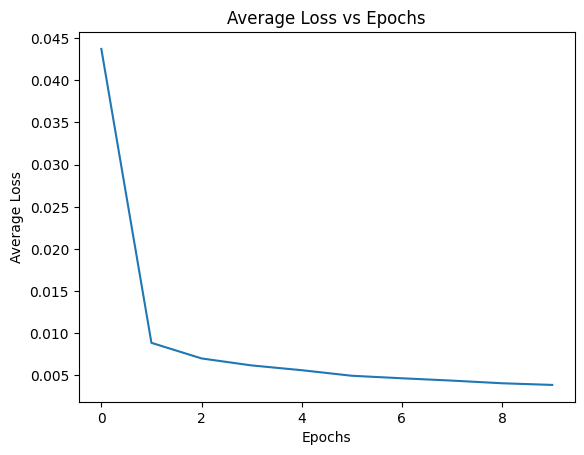

Accuracy of the LogisticRegression model on the test images: 99.90543365478516 %


In [56]:
model = 'logistic'
optimizer = 'momentum'
visualize = False
# Initialize
model, optimizer, criterion, train_loader, validation_loader, test_loader = initailize(
    model, optimizer, learning_rate)
# Train model
avg_loss_list = train_model(
    model, optimizer, criterion, train_loader, validation_loader, num_epochs, use_cuda)

# Visualize loss
visualize_loss(avg_loss_list)

# Test model
test_model(model, test_loader, use_cuda, visualize)

# Compare the models

Model: logistic, Optimizer: sgd, Learning Rate: 0.01
Epoch: [1/10], Avg Loss: 0.0900, Validation Accuracy: 99.6052 %
Epoch: [2/10], Avg Loss: 0.0251, Validation Accuracy: 99.7079 %
Epoch: [3/10], Avg Loss: 0.0180, Validation Accuracy: 99.7394 %
Epoch: [4/10], Avg Loss: 0.0147, Validation Accuracy: 99.7552 %
Epoch: [5/10], Avg Loss: 0.0128, Validation Accuracy: 99.7789 %
Epoch: [6/10], Avg Loss: 0.0114, Validation Accuracy: 99.7868 %
Epoch: [7/10], Avg Loss: 0.0104, Validation Accuracy: 99.7868 %
Epoch: [8/10], Avg Loss: 0.0098, Validation Accuracy: 99.7868 %
Epoch: [9/10], Avg Loss: 0.0093, Validation Accuracy: 99.7947 %
Epoch: [10/10], Avg Loss: 0.0088, Validation Accuracy: 99.7947 %
Model: logistic, Optimizer: momentum, Learning Rate: 0.01
Epoch: [1/10], Avg Loss: 0.0487, Validation Accuracy: 99.6684 %
Epoch: [2/10], Avg Loss: 0.0088, Validation Accuracy: 99.7473 %
Epoch: [3/10], Avg Loss: 0.0076, Validation Accuracy: 99.7868 %
Epoch: [4/10], Avg Loss: 0.0063, Validation Accuracy: 99

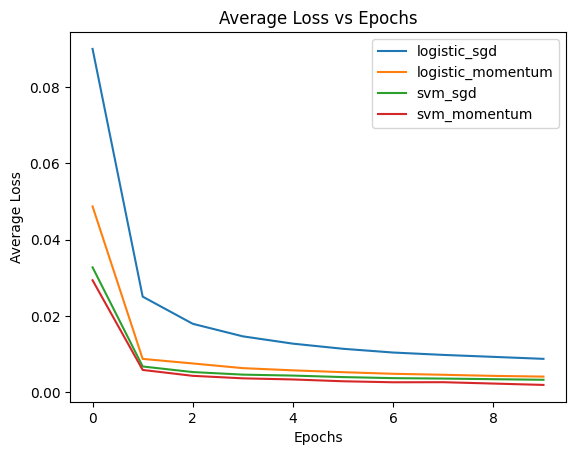

In [57]:
avg_loss_list_list = []
labels = []

for model_name in ['logistic', 'svm']:
    for optimizer_name in ['sgd', 'momentum']:
        # Initialize
        model, optimizer, criterion, train_loader, validation_loader, test_loader = initailize(
            model_name, optimizer_name, learning_rate)
        # Train model
        avg_loss_list = train_model(
            model, optimizer, criterion, train_loader, validation_loader, num_epochs, use_cuda)
        avg_loss_list_list.append(avg_loss_list)
        labels.append(model_name + '_' + optimizer_name)

draw_plots(avg_loss_list_list, labels)

# Compare the learning rates

Model: logistic, Optimizer: momentum, Learning Rate: 0.001
Epoch: [1/10], Avg Loss: 0.1494, Validation Accuracy: 99.5263 %
Epoch: [2/10], Avg Loss: 0.0371, Validation Accuracy: 99.6289 %
Epoch: [3/10], Avg Loss: 0.0266, Validation Accuracy: 99.7000 %
Epoch: [4/10], Avg Loss: 0.0219, Validation Accuracy: 99.7315 %
Epoch: [5/10], Avg Loss: 0.0186, Validation Accuracy: 99.7315 %
Epoch: [6/10], Avg Loss: 0.0166, Validation Accuracy: 99.7315 %
Epoch: [7/10], Avg Loss: 0.0151, Validation Accuracy: 99.7394 %
Epoch: [8/10], Avg Loss: 0.0139, Validation Accuracy: 99.7394 %
Epoch: [9/10], Avg Loss: 0.0130, Validation Accuracy: 99.7473 %
Epoch: [10/10], Avg Loss: 0.0122, Validation Accuracy: 99.7473 %
Model: logistic, Optimizer: momentum, Learning Rate: 0.01
Epoch: [1/10], Avg Loss: 0.0353, Validation Accuracy: 99.7552 %
Epoch: [2/10], Avg Loss: 0.0081, Validation Accuracy: 99.7868 %
Epoch: [3/10], Avg Loss: 0.0068, Validation Accuracy: 99.8105 %
Epoch: [4/10], Avg Loss: 0.0058, Validation Accura

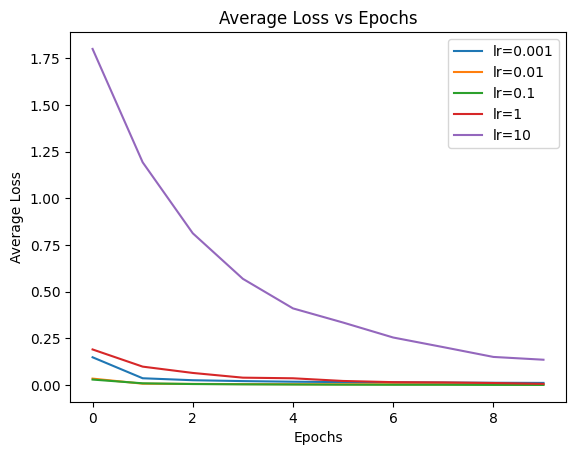

In [58]:
avg_loss_list_list = []
labels = []
for lr in [0.001, 0.01, 0.1, 1, 10]:
    # Initialize
    model, optimizer, criterion, train_loader, validation_loader, test_loader = initailize(
        'logistic', 'momentum', lr)
    # Train model
    avg_loss_list = train_model(
        model, optimizer, criterion, train_loader, validation_loader, num_epochs, use_cuda)
    avg_loss_list_list.append(avg_loss_list)
    labels.append('lr=' + str(lr))

draw_plots(avg_loss_list_list, labels)